## Import necessary modules


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
os.chdir('drive/My Drive/Neural/SSM/Neural Analysis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [ ]:
if not os.path.isdir('lfads_demo'):
  !git clone https://github.com/lyprince/lfads_demo 
#os.chdir('lfads_demo')
sys.path.append(os.path.join(os.getcwd(), 'lfads_demo')) # To find local version of the library

In [ ]:
sys.path.append(os.getcwd())

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml


# import lfads_tutorial.lfads as lfads
# import lfads_tutorial.plotting as plotting
# import lfads_tutorial.utils as utils
# from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun

from lfads import LFADS_Net 
from utils import read_data, load_parameters, save_parameters

In [ ]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [ ]:
from scipy import io as sio
LATENCY = 5
assert LATENCY in [5,25]
mult = 2.5 if LATENCY == 5 else 0.5
mat = sio.loadmat(f'./chewie_CO_CS_BL_10212016_001_py_{LATENCY}ms')

num_cells = {'pmd':mat['neural_data_PMd'][0,0].shape[0], 
             'm1': mat['neural_data_M1'][0,0].shape[0],
             'all': mat['neural_data_PMd'][0,0].shape[0] +  mat['neural_data_M1'][0,0].shape[0]}

num_trials = mat['neural_data_PMd'].shape[1]

kin=mat['kinematics']
go_time_rel = mat['go_time_rel']
move_time_rel = mat['move_time_rel']
## find when cue is on to align all trials
kin_dt = 0.01
cue_on_bin= [int(mat['go_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['go_time_rel'].shape[1])]
move_bin= [int(mat['move_time_rel'][0,i][0,0]/kin_dt/mult) for i in range(mat['move_time_rel'].shape[1])]


ys = {'pmd':[], 'm1':[], 'all':[]}
for trial in range(num_trials):
  ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial].T,mat['neural_data_M1'][0,trial].T], axis = 1).astype(int))
  ys['pmd'].append((mat['neural_data_PMd'][0,trial].T).astype(int))
  ys['m1'].append((mat['neural_data_M1'][0,trial].T).astype(int))

#time_delta = 20
# ys = {'pmd':[], 'm1':[], 'all':[]}
# for trial in range(num_trials):
#   ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T,mat['neural_data_M1'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T], axis = 1).astype(int))
#   ys['pmd'].append((mat['neural_data_PMd'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T).astype(int))
#   ys['m1'].append((mat['neural_data_M1'][0,trial][:,cue_on_bin[trial]:cue_on_bin[trial]+time_delta].T).astype(int))

# ys = {'pmd':[], 'm1':[], 'all':[]}
# for trial in range(num_trials):
#   ys['all'].append(np.concatenate([mat['neural_data_PMd'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T,mat['neural_data_M1'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T], axis = 1).astype(int))
#   ys['pmd'].append((mat['neural_data_PMd'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T).astype(int))
#   ys['m1'].append((mat['neural_data_M1'][0,trial][:,move_bin[trial]-time_delta:move_bin[trial]].T).astype(int))


50
89
184


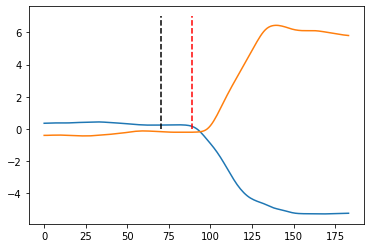

In [ ]:
#Plot position for first trial
import random
tr=random.randint(0,num_trials)
print(tr)
kin_dt = 0.01
go_cue_bin=int(go_time_rel[0,tr]/kin_dt)
move_bin=int(move_time_rel[0,tr]/kin_dt)

plt.plot(kin[0,tr][:,:2]) #Plot position
plt.plot([go_cue_bin,go_cue_bin],[0,7],'k--')
plt.plot([move_bin,move_bin],[0,7],'r--')
print(move_bin)
print(len(kin[0,tr]))
#print(neural_data_M1[0,tr].shape[1])

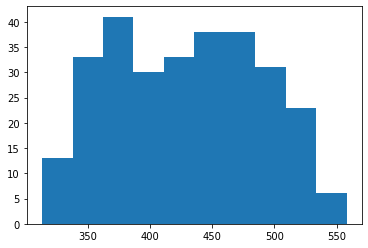

In [ ]:
# TODO: What should I do here? 
plt.hist([y.shape[0] for y in ys['all']]);

In [ ]:
num_steps = max([y.shape[0] for y in ys['all']])
ys_padded = {'all' :np.array([np.pad(ys['all'][i],((0,num_steps - ys['all'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
             'm1': np.array([np.pad(ys['m1'][i],((0,num_steps - ys['m1'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)]),
             'pmd': np.array([np.pad(ys['pmd'][i],((0,num_steps - ys['pmd'][i].shape[0]),(0,0),), constant_values = 0) for i in range(num_trials)])}

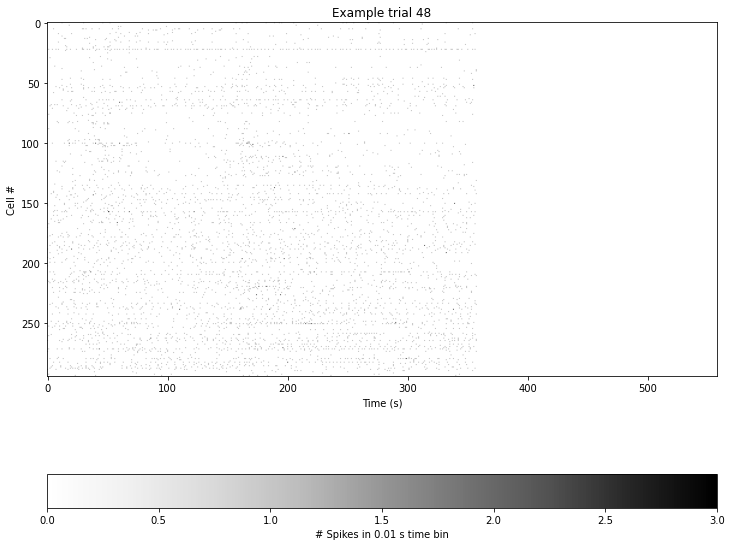

In [ ]:
plt.figure(figsize = (12,12))
random_trial = np.random.randint(num_trials)
plt.imshow(ys_padded['all'][random_trial].T, cmap=plt.cm.Greys)
#plt.xticks(np.linspace(0, 75, 6))
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='# Spikes in 0.01 s time bin')
plt.title(f'Example trial {random_trial}');

## Instantiate LFADS model

In [ ]:
DATASET = 'pmd'

train_data = torch.Tensor(ys_padded[DATASET]).to(device)
train_ds = torch.utils.data.TensorDataset(train_data)

valid_data = torch.Tensor(ys_padded[DATASET][[10],:,:]).to(device)
valid_ds = torch.utils.data.TensorDataset(valid_data)

hyperparams = load_parameters('lfads_demo/parameters_demo.yaml')
#save_parameters(hyperparams)
hyperparams['run_name'] = f'master_run_{LATENCY}ms_{DATASET}'
hyperparams['dataset_name'] = DATASET
# hyperparams['g_dim'] = 4
# hyperparams['g0_encoder_dim'] = 128
# hyperparams['controller_dim'] = 128
# hyperparams['c_encoder_dim'] = 128
model = LFADS_Net(inputs_dim = num_cells[DATASET], T = num_steps, dt = 1, device=device, model_hyperparams=hyperparams, seed = 0).to(device)

Preset seed: 0


In [ ]:
hyperparams

{'betas': (0.9, 0.99),
 'c_encoder_dim': 128,
 'clip_val': 5.0,
 'controller_dim': 128,
 'dataset_name': 'pmd',
 'epsilon': 0.1,
 'factors_dim': 20,
 'g0_encoder_dim': 200,
 'g0_prior_kappa': 0.1,
 'g_dim': 200,
 'keep_prob': 0.95,
 'kl_weight_schedule_dur': 2000,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 2000,
 'l2_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'run_name': 'master_run_5ms_pmd',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 1,
 'u_prior_kappa': 0.1}

In [ ]:
model.load_checkpoint('recent')

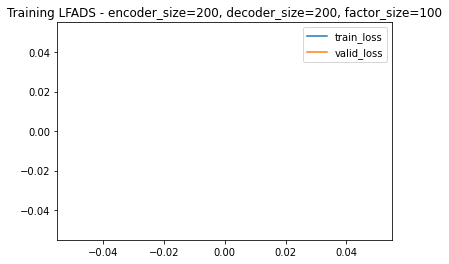

In [ ]:
plt.plot(model.train_loss_store[10:], label = 'train_loss')
plt.plot(model.valid_loss_store[10:], label = 'valid_loss')
plt.legend()
plt.title('Training LFADS - encoder_size=200, decoder_size=200, factor_size=100')
plt.show()

Beginning training...
Epoch:    1, Step:     5, training loss: 100463.305, validation loss: 69418.078
Epoch:    2, Step:    10, training loss: 41836.477, validation loss: 41066.562
Epoch:    3, Step:    15, training loss: 17564.012, validation loss: 25971.771
Epoch:    4, Step:    20, training loss: 14334.726, validation loss: 16046.479
Epoch:    5, Step:    25, training loss: 13905.419, validation loss: 13618.790
Epoch:    6, Step:    30, training loss: 13722.194, validation loss: 12883.333
Epoch:    7, Step:    35, training loss: 13671.578, validation loss: 12786.979
Epoch:    8, Step:    40, training loss: 13661.422, validation loss: 12839.760
Epoch:    9, Step:    45, training loss: 13680.343, validation loss: 12626.634
Epoch:   10, Step:    50, training loss: 13653.114, validation loss: 12846.733
Epoch:   11, Step:    55, training loss: 13656.331, validation loss: 12617.810
Epoch:   12, Step:    60, training loss: 13657.312, validation loss: 12452.233
Epoch:   13, Step:    65, tra

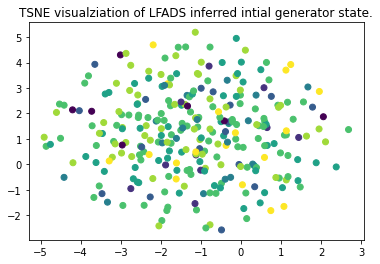

Beginning training...
Epoch:   51, Step:   255, training loss: 12496.697, validation loss: 11407.561
Epoch:   52, Step:   260, training loss: 12443.038, validation loss: 11411.629
Epoch:   53, Step:   265, training loss: 12449.089, validation loss: 11347.342
Epoch:   54, Step:   270, training loss: 12444.192, validation loss: 11379.764
Epoch:   55, Step:   275, training loss: 12361.203, validation loss: 11326.322
Epoch:   56, Step:   280, training loss: 12391.245, validation loss: 11304.481
Epoch:   57, Step:   285, training loss: 12391.432, validation loss: 11367.235
Epoch:   58, Step:   290, training loss: 12392.056, validation loss: 11337.205
Epoch:   59, Step:   295, training loss: 12381.669, validation loss: 11271.849
Epoch:   60, Step:   300, training loss: 12338.025, validation loss: 11293.910
Epoch:   61, Step:   305, training loss: 12336.161, validation loss: 11251.839
Epoch:   62, Step:   310, training loss: 12357.339, validation loss: 11248.339
Epoch:   63, Step:   315, trai

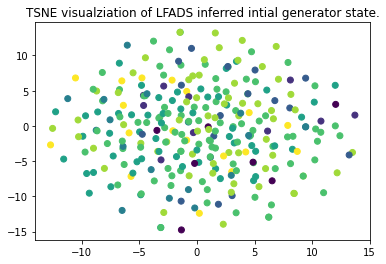

Beginning training...
Epoch:  101, Step:   505, training loss: 12208.675, validation loss: 11032.930
Epoch:  102, Step:   510, training loss: 12184.039, validation loss: 11035.936
Epoch:  103, Step:   515, training loss: 12190.372, validation loss: 10984.021
Epoch:  104, Step:   520, training loss: 12170.890, validation loss: 10980.858
Epoch:  105, Step:   525, training loss: 12216.561, validation loss: 11027.952
Epoch:  106, Step:   530, training loss: 12193.912, validation loss: 11166.937
Epoch:  107, Step:   535, training loss: 12306.266, validation loss: 11014.876
Learning rate decreased to 0.00814506
Epoch:  108, Step:   540, training loss: 12190.469, validation loss: 11022.954
Epoch:  109, Step:   545, training loss: 12167.987, validation loss: 10996.336
Epoch:  110, Step:   550, training loss: 12226.245, validation loss: 10990.872
Epoch:  111, Step:   555, training loss: 12148.666, validation loss: 10962.362
Epoch:  112, Step:   560, training loss: 12207.971, validation loss: 10

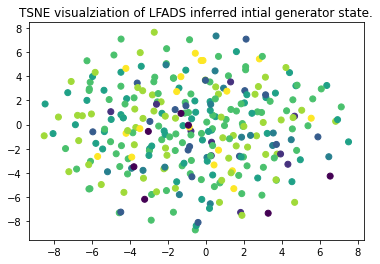

Beginning training...
Epoch:  151, Step:   755, training loss: 12133.763, validation loss: 10984.974
Epoch:  152, Step:   760, training loss: 12167.372, validation loss: 10871.028
Epoch:  153, Step:   765, training loss: 12173.348, validation loss: 10874.825
Epoch:  154, Step:   770, training loss: 12137.434, validation loss: 10879.787
Epoch:  155, Step:   775, training loss: 12219.685, validation loss: 10941.548
Learning rate decreased to 0.00698337
Epoch:  156, Step:   780, training loss: 12161.534, validation loss: 10956.711
Epoch:  157, Step:   785, training loss: 12221.166, validation loss: 10904.074
Epoch:  158, Step:   790, training loss: 12213.366, validation loss: 10864.689
Epoch:  159, Step:   795, training loss: 12192.140, validation loss: 11051.385
Epoch:  160, Step:   800, training loss: 12239.925, validation loss: 10901.386
Epoch:  161, Step:   805, training loss: 12159.046, validation loss: 11017.269
Epoch:  162, Step:   810, training loss: 12098.861, validation loss: 10

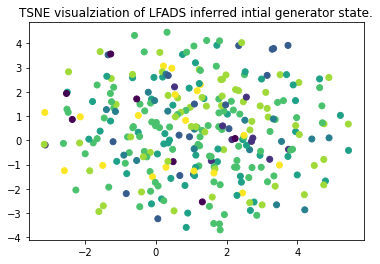

Beginning training...
Epoch:  201, Step:  1005, training loss: 12179.185, validation loss: 11039.475
Epoch:  202, Step:  1010, training loss: 12175.338, validation loss: 10860.777
Epoch:  203, Step:  1015, training loss: 12135.862, validation loss: 10864.348
Epoch:  204, Step:  1020, training loss: 12230.462, validation loss: 11073.331
Learning rate decreased to 0.00568800
Epoch:  205, Step:  1025, training loss: 12175.046, validation loss: 10852.636
Epoch:  206, Step:  1030, training loss: 12165.917, validation loss: 10972.218
Epoch:  207, Step:  1035, training loss: 12231.999, validation loss: 10939.537
Epoch:  208, Step:  1040, training loss: 12225.276, validation loss: 10998.888
Epoch:  209, Step:  1045, training loss: 12169.383, validation loss: 10845.425
Epoch:  210, Step:  1050, training loss: 12227.698, validation loss: 10823.950
Epoch:  211, Step:  1055, training loss: 12208.878, validation loss: 10817.829
Epoch:  212, Step:  1060, training loss: 12239.068, validation loss: 10

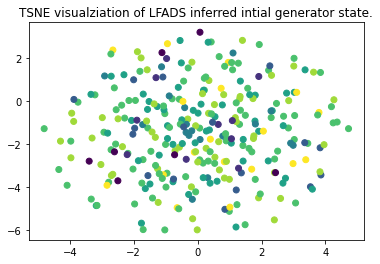

Beginning training...
Epoch:  251, Step:  1255, training loss: 12259.624, validation loss: 11011.773
Learning rate decreased to 0.00440127
Epoch:  252, Step:  1260, training loss: 12205.640, validation loss: 10979.493
Epoch:  253, Step:  1265, training loss: 12217.566, validation loss: 11053.983
Epoch:  254, Step:  1270, training loss: 12168.544, validation loss: 11110.366
Epoch:  255, Step:  1275, training loss: 12248.878, validation loss: 11064.599
Epoch:  256, Step:  1280, training loss: 12225.498, validation loss: 11048.461
Epoch:  257, Step:  1285, training loss: 12206.514, validation loss: 11031.433
Epoch:  258, Step:  1290, training loss: 12221.691, validation loss: 11003.901
Epoch:  259, Step:  1295, training loss: 12240.128, validation loss: 11022.320
Epoch:  260, Step:  1300, training loss: 12178.617, validation loss: 11062.338
Epoch:  261, Step:  1305, training loss: 12212.896, validation loss: 11006.814
Epoch:  262, Step:  1310, training loss: 12286.854, validation loss: 10

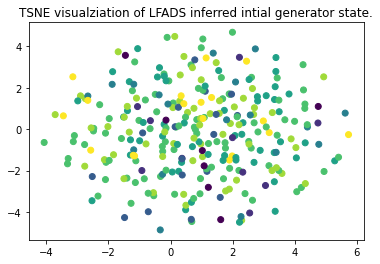

Beginning training...
Epoch:  301, Step:  1505, training loss: 12245.706, validation loss: 11018.160
Epoch:  302, Step:  1510, training loss: 12240.734, validation loss: 11072.948
Epoch:  303, Step:  1515, training loss: 12186.979, validation loss: 10987.749
Epoch:  304, Step:  1520, training loss: 12215.973, validation loss: 11030.173
Epoch:  305, Step:  1525, training loss: 12303.975, validation loss: 11022.363
Learning rate decreased to 0.00340562
Epoch:  306, Step:  1530, training loss: 12213.147, validation loss: 11025.764
Epoch:  307, Step:  1535, training loss: 12222.385, validation loss: 11075.021
Epoch:  308, Step:  1540, training loss: 12172.034, validation loss: 11165.870
Epoch:  309, Step:  1545, training loss: 12316.788, validation loss: 11043.496
Epoch:  310, Step:  1550, training loss: 12274.494, validation loss: 11039.648
Epoch:  311, Step:  1555, training loss: 12190.858, validation loss: 11097.597
Epoch:  312, Step:  1560, training loss: 12227.203, validation loss: 11

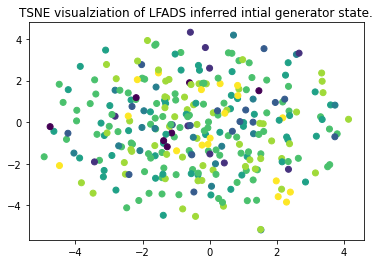

Beginning training...
Epoch:  351, Step:  1755, training loss: 12321.468, validation loss: 11076.168
Learning rate decreased to 0.00263520
Epoch:  352, Step:  1760, training loss: 12246.900, validation loss: 11119.661
Epoch:  353, Step:  1765, training loss: 12262.388, validation loss: 11120.708
Epoch:  354, Step:  1770, training loss: 12318.817, validation loss: 11061.091
Epoch:  355, Step:  1775, training loss: 12271.417, validation loss: 11062.164
Epoch:  356, Step:  1780, training loss: 12307.134, validation loss: 11105.080
Epoch:  357, Step:  1785, training loss: 12234.933, validation loss: 11053.649
Epoch:  358, Step:  1790, training loss: 12305.519, validation loss: 11075.410
Epoch:  359, Step:  1795, training loss: 12256.094, validation loss: 11155.340
Epoch:  360, Step:  1800, training loss: 12236.327, validation loss: 11083.869
Epoch:  361, Step:  1805, training loss: 12230.010, validation loss: 11128.545
Epoch:  362, Step:  1810, training loss: 12273.636, validation loss: 11

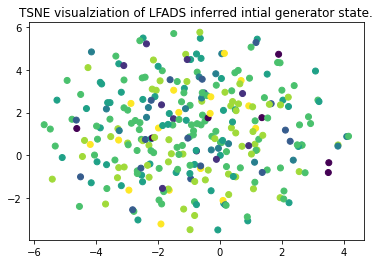

Beginning training...
Epoch:  401, Step:  2005, training loss: 12235.753, validation loss: 11098.729
Epoch:  402, Step:  2010, training loss: 12306.481, validation loss: 11063.732
Epoch:  403, Step:  2015, training loss: 12344.706, validation loss: 11117.887
Learning rate decreased to 0.00203907
Epoch:  404, Step:  2020, training loss: 12298.709, validation loss: 11126.649
Epoch:  405, Step:  2025, training loss: 12256.831, validation loss: 11120.171
Epoch:  406, Step:  2030, training loss: 12283.636, validation loss: 11069.811
Epoch:  407, Step:  2035, training loss: 12245.558, validation loss: 11069.984
Epoch:  408, Step:  2040, training loss: 12311.330, validation loss: 11037.068
Epoch:  409, Step:  2045, training loss: 12335.958, validation loss: 11044.539
Epoch:  410, Step:  2050, training loss: 12311.132, validation loss: 11191.334
Epoch:  411, Step:  2055, training loss: 12281.225, validation loss: 11116.309
Epoch:  412, Step:  2060, training loss: 12273.243, validation loss: 11

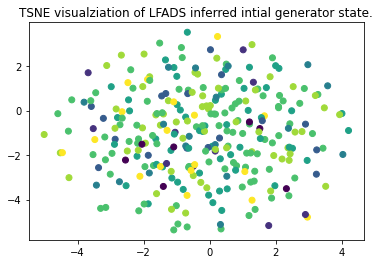

Beginning training...
Epoch:  451, Step:  2255, training loss: 12270.411, validation loss: 11161.197
Epoch:  452, Step:  2260, training loss: 12311.825, validation loss: 11067.952
Epoch:  453, Step:  2265, training loss: 12285.861, validation loss: 11126.877
Epoch:  454, Step:  2270, training loss: 12269.977, validation loss: 11120.442
Epoch:  455, Step:  2275, training loss: 12360.791, validation loss: 11116.391
Learning rate decreased to 0.00157779
Epoch:  456, Step:  2280, training loss: 12301.619, validation loss: 11117.117
Epoch:  457, Step:  2285, training loss: 12254.189, validation loss: 11122.276
Epoch:  458, Step:  2290, training loss: 12330.161, validation loss: 11072.929
Epoch:  459, Step:  2295, training loss: 12268.950, validation loss: 11156.734
Epoch:  460, Step:  2300, training loss: 12232.586, validation loss: 11161.395
Epoch:  461, Step:  2305, training loss: 12284.582, validation loss: 11084.632
Epoch:  462, Step:  2310, training loss: 12271.631, validation loss: 11

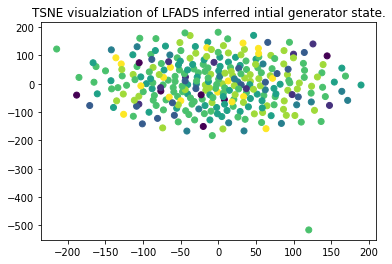

Beginning training...
Epoch:  501, Step:  2505, training loss: 12278.283, validation loss: 11090.177
Epoch:  502, Step:  2510, training loss: 12265.375, validation loss: 11180.799
Epoch:  503, Step:  2515, training loss: 12211.440, validation loss: 11062.945
Epoch:  504, Step:  2520, training loss: 12307.577, validation loss: 11113.263
Learning rate decreased to 0.00128512
Epoch:  505, Step:  2525, training loss: 12369.710, validation loss: 11381.110
Epoch:  506, Step:  2530, training loss: 12265.547, validation loss: 11127.368
Epoch:  507, Step:  2535, training loss: 12272.340, validation loss: 11147.566
Epoch:  508, Step:  2540, training loss: 12263.766, validation loss: 11077.534
Epoch:  509, Step:  2545, training loss: 12317.880, validation loss: 11114.519
Epoch:  510, Step:  2550, training loss: 12280.854, validation loss: 11098.233
Epoch:  511, Step:  2555, training loss: 12262.810, validation loss: 11111.113
Epoch:  512, Step:  2560, training loss: 12283.105, validation loss: 11

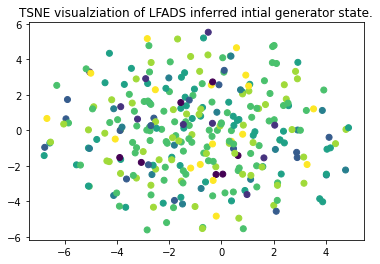

Beginning training...
Epoch:  551, Step:  2755, training loss: 12248.804, validation loss: 11109.454
Epoch:  552, Step:  2760, training loss: 12244.222, validation loss: 11139.770
Epoch:  553, Step:  2765, training loss: 12185.651, validation loss: 11104.106
Epoch:  554, Step:  2770, training loss: 12239.556, validation loss: 12011.301
Epoch:  555, Step:  2775, training loss: 12287.788, validation loss: 11095.196
Learning rate decreased to 0.00099440
Epoch:  556, Step:  2780, training loss: 12328.995, validation loss: 11083.426
Epoch:  557, Step:  2785, training loss: 12281.858, validation loss: 11092.152
Epoch:  558, Step:  2790, training loss: 12242.468, validation loss: 11652.553
Epoch:  559, Step:  2795, training loss: 12262.330, validation loss: 11100.854
Epoch:  560, Step:  2800, training loss: 12264.354, validation loss: 11182.536
Epoch:  561, Step:  2805, training loss: 12264.071, validation loss: 11123.838
Epoch:  562, Step:  2810, training loss: 12229.550, validation loss: 11

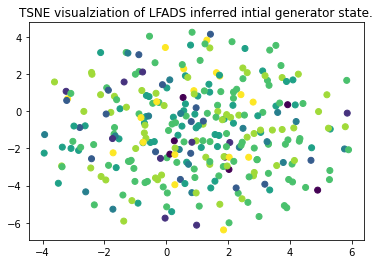

Beginning training...
Epoch:  601, Step:  3005, training loss: 12270.656, validation loss: 11265.596
Epoch:  602, Step:  3010, training loss: 12266.557, validation loss: 11247.779
Epoch:  603, Step:  3015, training loss: 12226.312, validation loss: 11101.038
Epoch:  604, Step:  3020, training loss: 12223.424, validation loss: 11128.508
Epoch:  605, Step:  3025, training loss: 12252.358, validation loss: 11161.559
Epoch:  606, Step:  3030, training loss: 12246.298, validation loss: 11304.762
Epoch:  607, Step:  3035, training loss: 12278.710, validation loss: 11119.357
Learning rate decreased to 0.00076945
Epoch:  608, Step:  3040, training loss: 12254.673, validation loss: 11301.623
Epoch:  609, Step:  3045, training loss: 12211.122, validation loss: 11058.781
Epoch:  610, Step:  3050, training loss: 12267.031, validation loss: 11214.883
Epoch:  611, Step:  3055, training loss: 12237.585, validation loss: 11404.187
Epoch:  612, Step:  3060, training loss: 12225.565, validation loss: 11

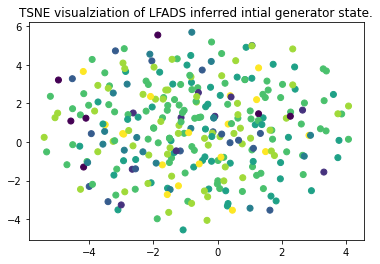

Beginning training...
Epoch:  651, Step:  3255, training loss: 12212.789, validation loss: 11212.607
Epoch:  652, Step:  3260, training loss: 12278.160, validation loss: 11314.151
Epoch:  653, Step:  3265, training loss: 12254.991, validation loss: 11099.604
Epoch:  654, Step:  3270, training loss: 12282.751, validation loss: 11173.158
Epoch:  655, Step:  3275, training loss: 12258.818, validation loss: 11082.057
Epoch:  656, Step:  3280, training loss: 12201.253, validation loss: 11124.386
Epoch:  657, Step:  3285, training loss: 12227.814, validation loss: 11096.920
Epoch:  658, Step:  3290, training loss: 12192.793, validation loss: 11205.379
Epoch:  659, Step:  3295, training loss: 12222.722, validation loss: 11082.065
Epoch:  660, Step:  3300, training loss: 12267.593, validation loss: 11905.256
Epoch:  661, Step:  3305, training loss: 12306.844, validation loss: 11101.239
Learning rate decreased to 0.00059539
Epoch:  662, Step:  3310, training loss: 12253.459, validation loss: 11

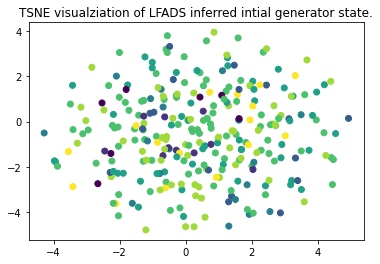

Beginning training...
Epoch:  701, Step:  3505, training loss: 12274.393, validation loss: 11252.199
Epoch:  702, Step:  3510, training loss: 12261.726, validation loss: 11076.869
Epoch:  703, Step:  3515, training loss: 12233.414, validation loss: 11089.749
Epoch:  704, Step:  3520, training loss: 12278.570, validation loss: 11109.534
Learning rate decreased to 0.00051047
Epoch:  705, Step:  3525, training loss: 12260.604, validation loss: 11114.899
Epoch:  706, Step:  3530, training loss: 12245.925, validation loss: 11195.733
Epoch:  707, Step:  3535, training loss: 12276.413, validation loss: 11111.948
Epoch:  708, Step:  3540, training loss: 12258.924, validation loss: 11134.548
Epoch:  709, Step:  3545, training loss: 12245.029, validation loss: 11128.163
Epoch:  710, Step:  3550, training loss: 12330.046, validation loss: 11108.024
Learning rate decreased to 0.00048495
Epoch:  711, Step:  3555, training loss: 12254.305, validation loss: 11110.764
Epoch:  712, Step:  3560, trainin

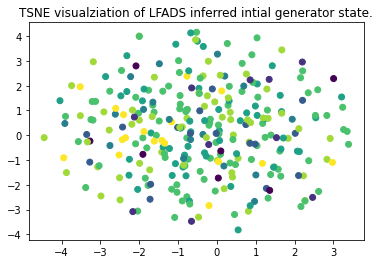

Beginning training...
Epoch:  751, Step:  3755, training loss: 12229.842, validation loss: 11237.459
Epoch:  752, Step:  3760, training loss: 12267.383, validation loss: 11082.218
Learning rate decreased to 0.00039499
Epoch:  753, Step:  3765, training loss: 12258.744, validation loss: 11130.988
Epoch:  754, Step:  3770, training loss: 12295.226, validation loss: 11087.610
Epoch:  755, Step:  3775, training loss: 12249.555, validation loss: 11099.089
Epoch:  756, Step:  3780, training loss: 12254.575, validation loss: 11067.110
Epoch:  757, Step:  3785, training loss: 12240.054, validation loss: 11150.051
Epoch:  758, Step:  3790, training loss: 12245.139, validation loss: 11158.586
Epoch:  759, Step:  3795, training loss: 12240.762, validation loss: 11697.938
Epoch:  760, Step:  3800, training loss: 12239.464, validation loss: 11919.198
Epoch:  761, Step:  3805, training loss: 12264.385, validation loss: 11159.225
Learning rate decreased to 0.00037524
Epoch:  762, Step:  3810, trainin

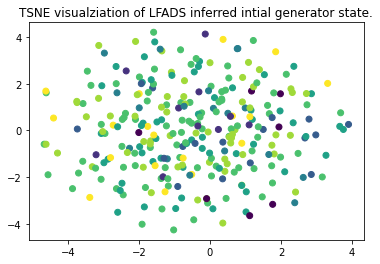

Beginning training...
Epoch:  801, Step:  4005, training loss: 12262.877, validation loss: 11078.991
Epoch:  802, Step:  4010, training loss: 12224.742, validation loss: 11078.492
Epoch:  803, Step:  4015, training loss: 12262.068, validation loss: 11630.863
Epoch:  804, Step:  4020, training loss: 12221.175, validation loss: 11518.807
Epoch:  805, Step:  4025, training loss: 12209.071, validation loss: 11510.919
Epoch:  806, Step:  4030, training loss: 12255.513, validation loss: 11288.218
Epoch:  807, Step:  4035, training loss: 12216.597, validation loss: 11248.825
Epoch:  808, Step:  4040, training loss: 12265.300, validation loss: 11559.935
Learning rate decreased to 0.00029035
Epoch:  809, Step:  4045, training loss: 12246.390, validation loss: 11102.814
Epoch:  810, Step:  4050, training loss: 12295.429, validation loss: 11125.221
Epoch:  811, Step:  4055, training loss: 12309.250, validation loss: 12045.704
Epoch:  812, Step:  4060, training loss: 12248.005, validation loss: 11

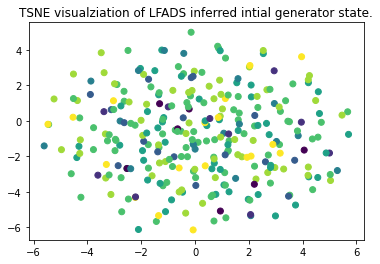

Beginning training...
Epoch:  851, Step:  4255, training loss: 12230.160, validation loss: 11355.197
Epoch:  852, Step:  4260, training loss: 12253.263, validation loss: 11100.348
Epoch:  853, Step:  4265, training loss: 12270.271, validation loss: 11273.254
Epoch:  854, Step:  4270, training loss: 12237.769, validation loss: 11808.405
Epoch:  855, Step:  4275, training loss: 12286.162, validation loss: 11600.256
Learning rate decreased to 0.00022467
Epoch:  856, Step:  4280, training loss: 12308.799, validation loss: 12072.063
Epoch:  857, Step:  4285, training loss: 12268.534, validation loss: 11307.844
Epoch:  858, Step:  4290, training loss: 12271.464, validation loss: 11196.864
Epoch:  859, Step:  4295, training loss: 12194.802, validation loss: 11042.898
Epoch:  860, Step:  4300, training loss: 12238.451, validation loss: 11151.414
Epoch:  861, Step:  4305, training loss: 12273.472, validation loss: 11264.707
Epoch:  862, Step:  4310, training loss: 12252.251, validation loss: 11

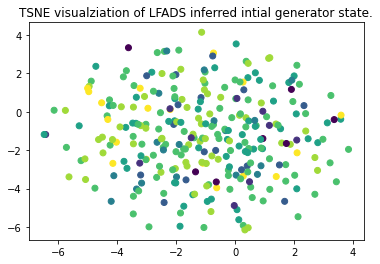

Beginning training...
Epoch:  901, Step:  4505, training loss: 12227.244, validation loss: 11227.315
Epoch:  902, Step:  4510, training loss: 12231.864, validation loss: 11245.820
Epoch:  903, Step:  4515, training loss: 12255.819, validation loss: 11196.679
Epoch:  904, Step:  4520, training loss: 12263.108, validation loss: 11737.966
Epoch:  905, Step:  4525, training loss: 12214.319, validation loss: 11620.050
Epoch:  906, Step:  4530, training loss: 12263.499, validation loss: 11235.675
Learning rate decreased to 0.00017385
Epoch:  907, Step:  4535, training loss: 12186.186, validation loss: 11245.558
Epoch:  908, Step:  4540, training loss: 12244.839, validation loss: 11299.649
Epoch:  909, Step:  4545, training loss: 12176.722, validation loss: 11109.574
Epoch:  910, Step:  4550, training loss: 12234.491, validation loss: 11542.266
Epoch:  911, Step:  4555, training loss: 12241.253, validation loss: 11130.938
Epoch:  912, Step:  4560, training loss: 12258.803, validation loss: 11

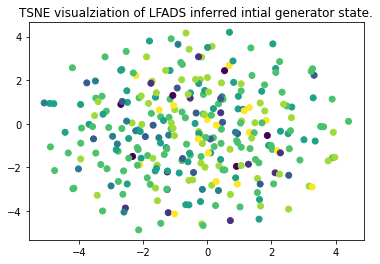

Beginning training...
Epoch:  951, Step:  4755, training loss: 12231.305, validation loss: 11188.460
Epoch:  952, Step:  4760, training loss: 12251.978, validation loss: 11111.562
Epoch:  953, Step:  4765, training loss: 12232.963, validation loss: 11306.042
Epoch:  954, Step:  4770, training loss: 12264.761, validation loss: 11132.680
Epoch:  955, Step:  4775, training loss: 12231.016, validation loss: 11133.205
Epoch:  956, Step:  4780, training loss: 12255.170, validation loss: 11072.638
Epoch:  957, Step:  4785, training loss: 12200.905, validation loss: 11070.864
Epoch:  958, Step:  4790, training loss: 12185.564, validation loss: 11334.485
Epoch:  959, Step:  4795, training loss: 12277.710, validation loss: 11264.990
Learning rate decreased to 0.00013452
Epoch:  960, Step:  4800, training loss: 12261.194, validation loss: 11499.886
Epoch:  961, Step:  4805, training loss: 12218.579, validation loss: 11310.383
Epoch:  962, Step:  4810, training loss: 12242.977, validation loss: 11

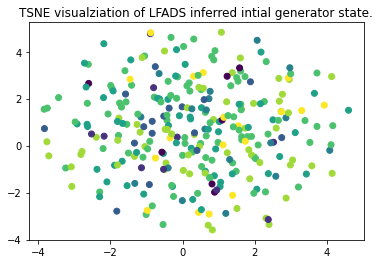

In [32]:
from sklearn.manifold import TSNE
import math
from lfads import batchify_random_sample

colors = [np.floor((np.arctan2(*kin[0,tr][0,:2])/np.pi+ 0.3)*4) for tr in range(num_trials)]
  
current_epochs = 0
for max_epochs in [50]*20:

  model.fit(
      train_ds, valid_ds, max_epochs=max_epochs, batch_size=64, use_tensorboard=False)#,train_truth=train_truth, valid_truth=valid_truth)

  model.save_checkpoint(force = True, output= '.')
  model.eval()
  model.batch_size = num_trials
  model.initialize(batch_size = num_trials)
  with torch.no_grad():
    model.encode(train_data)

  ic_means = model.g.to('cpu')
  ic_means_embedded = TSNE(n_components=2).fit_transform(ic_means)
  plt.scatter(ic_means_embedded[:,0], ic_means_embedded[:,1], c=  colors);
  plt.title('TSNE visualziation of LFADS inferred intial generator state.')
  plt.show()

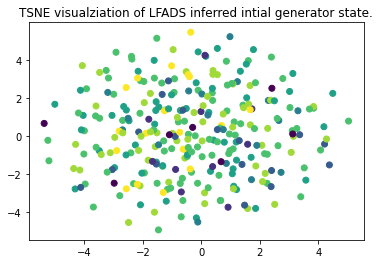

In [ ]:
model.eval()
model.batch_size = num_trials
model.initialize(batch_size = num_trials)
with torch.no_grad():
  model.encode(train_data)

ic_means = model.g.to('cpu')
ic_means_embedded = TSNE(n_components=2).fit_transform(ic_means)
plt.scatter(ic_means_embedded[:,0], ic_means_embedded[:,1], c=  colors);
plt.title('TSNE visualziation of LFADS inferred intial generator state.')
plt.show()

In [ ]:
# Let's try the next time in a bit

Two things:

1. Next steps
2. JAX implementation

Check on initial conditions

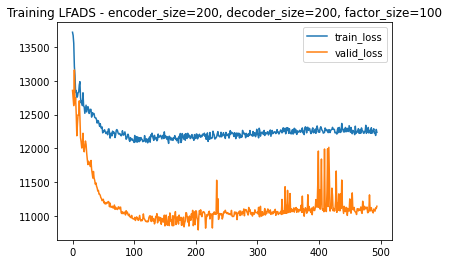

In [ ]:
plt.plot(model.train_loss_store[5:], label = 'train_loss')
plt.plot(model.valid_loss_store[5:], label = 'valid_loss')
plt.legend()
plt.title('Training LFADS - encoder_size=200, decoder_size=200, factor_size=100')
plt.show()

In [ ]:
batch_size = 20
xs_padded = []
factors_padded = [] 
for ix in range(ys_padded[DATASET].shape[0]):
  if ix%50 == 0:
    print(ix)
  batch = train_data[ix].unsqueeze(0).repeat(batch_size, 1,1)
  pred_data = model.reconstruct(batch)
  inferred_factors = model.infer_factors(batch)
  true_data = train_data[ix].cpu().numpy()
  xs_padded.append(pred_data)
  factors_padded.append(inferred_factors.mean(dim=0).cpu().numpy())
  #model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=4)

xs = [xs_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET])]
factors = [factors_padded[i][:y.shape[0],:] for i,y in enumerate(ys[DATASET])]

if not os.path.exists(f'./output/{model.run_name}_pmd'):
  os.mkdir(f'./output/{model.run_name}_pmd')
np.save(f'./output/{model.run_name}_pmd/xs_{DATASET}.npy', xs)
np.save(f'./output/{model.run_name}_pmd/xs_{DATASET}_padded.npy', xs_padded)
np.save(f'./output/{model.run_name}_pmd/factors_{DATASET}.npy', factors)
np.save(f'./output/{model.run_name}_pmd/factors_{DATASET}_padded.npy', factors_padded)
 

0
50
100
150
200
250


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


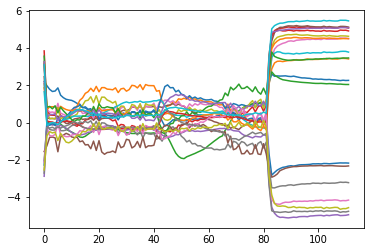

In [ ]:
plt.plot(inferred_factors_list[200].mean(dim = 0))

In [ ]:
model??

In [ ]:
ys_padded['all'].shape

(286, 112, 295)

In [ ]:
model.device

'cuda'

In [ ]:
model??

51


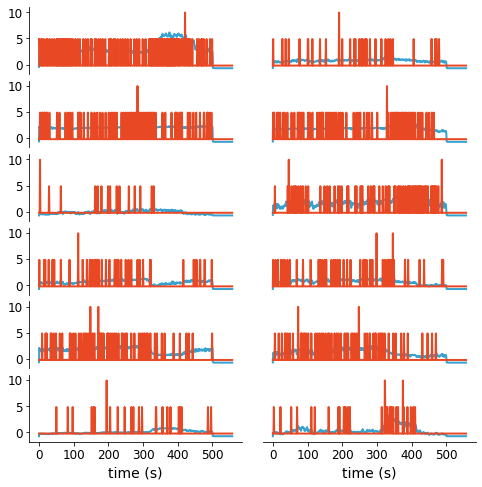

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(train_data, 20)
print(ix)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=12);
#plt.show()

0.21854073114160988


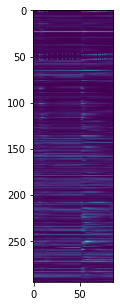

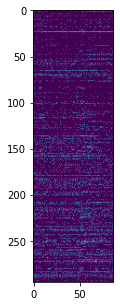

In [ ]:
from scipy.stats import poisson
import random
trial = random.randint(0,100)
print(poisson.pmf(ys[DATASET][trial].T,xs[trial].T)[ys[DATASET][trial].T !=0].mean())
plt.figure(figsize = (5,5))
plt.imshow(xs[trial].T)
plt.figure(figsize = (5,5))
plt.imshow(ys[DATASET][trial].T)

In [ ]:
#model.load_checkpoint('recent')

## Plot results summary 

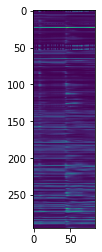

In [ ]:
plt.imshow(xs[100].T);

2


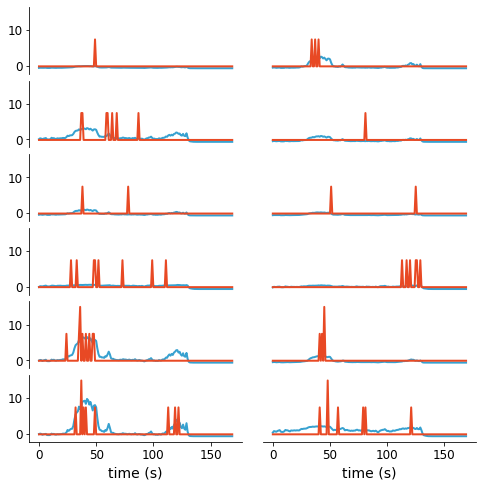

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(valid_data, 20)
print(ix)
pred_data = model.reconstruct(batch_example)*10
true_data = valid_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=12);
#plt.show()

In [ ]:
valid_data.shape

torch.Size([3, 170, 94])

In [ ]:
model.plot_traces??

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(train_data, 20)
print(ix)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=False,num_traces=6)

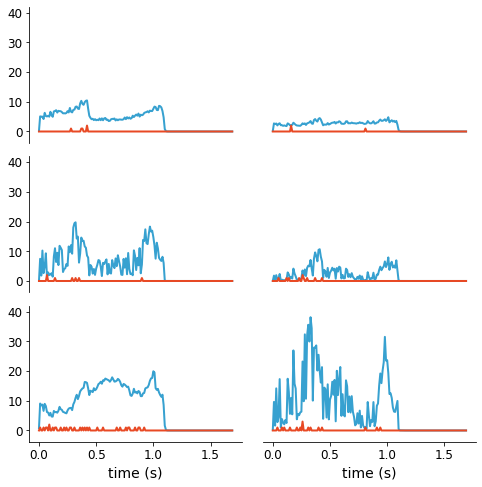

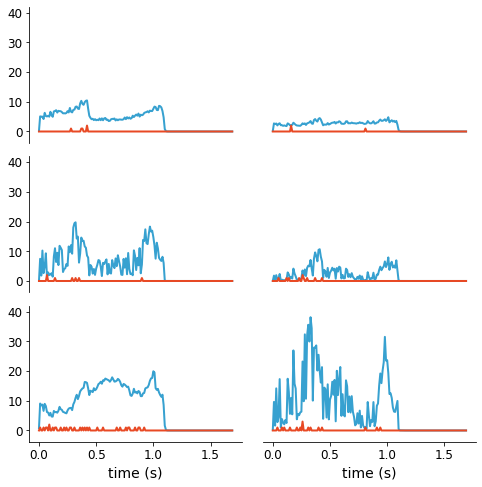

In [ ]:
batch_size = 100
ix = 0
batch = train_data[ix].unsqueeze(0).repeat(batch_size, 1, 1)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=False,num_traces=6)

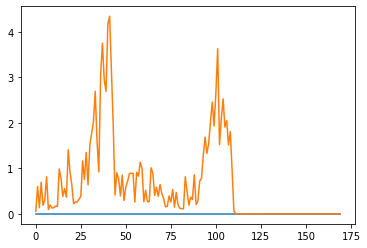

In [ ]:
plt.plot(true_data[:,1])
plt.plot(pred_data[:,1])
#plt.plot(ys['pmd'][0][:,1])  
plt.show()

In [ ]:
batchify_random_sample??

In [ ]:
model.plot_traces??

## Check iterations

In [ ]:
os.listdir('output/iterations')

['xs_pmd_500.npy',
 'xs_pmd_padded_500.npy',
 'xs_pmd_1000.npy',
 'xs_pmd_padded_1000.npy',
 'xs_pmd_1500.npy',
 'xs_pmd_padded_1500.npy',
 'xs_pmd_2000.npy',
 'xs_pmd_padded_2000.npy',
 'xs_pmd_2500.npy',
 'xs_pmd_padded_2500.npy',
 'xs_pmd_3000.npy',
 'xs_pmd_padded_3000.npy',
 'xs_pmd_3500.npy',
 'xs_pmd_padded_3500.npy',
 'xs_pmd_4000.npy',
 'xs_pmd_padded_4000.npy',
 'xs_pmd_4500.npy',
 'xs_pmd_padded_4500.npy',
 'xs_pmd_5000.npy',
 'xs_pmd_padded_5000.npy',
 'xs_pmd_5500.npy',
 'xs_pmd_padded_5500.npy',
 'xs_pmd_6000.npy',
 'xs_pmd_padded_6000.npy',
 'xs_pmd_6500.npy',
 'xs_pmd_padded_6500.npy',
 'xs_pmd_7000.npy',
 'xs_pmd_padded_7000.npy',
 'xs_pmd_7500.npy',
 'xs_pmd_padded_7500.npy',
 'xs_pmd_8000.npy',
 'xs_pmd_padded_8000.npy',
 'xs_pmd_8500.npy',
 'xs_pmd_padded_8500.npy',
 'xs_pmd_9000.npy',
 'xs_pmd_padded_9000.npy',
 'xs_pmd_9500.npy',
 'xs_pmd_padded_9500.npy',
 'xs_pmd_10000.npy',
 'xs_pmd_padded_10000.npy']

In [ ]:
xss = [np.load(f'output/iterations/xs_pmd_{i}.npy', allow_pickle = True) for i in range(500,10000,500)]
  

In [ ]:
for i in range(len(xss)):
  plt.imshow(xss[i][0].T)
  plt.show()

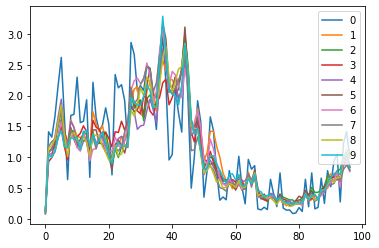

In [ ]:
for i in range(len(xss))[:10]:
  plt.plot(xss[i][0][:,1],label = i)
plt.legend()
plt.show()

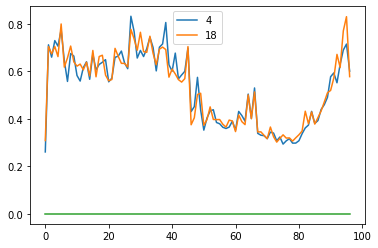

In [ ]:
for i in [4,18]:
  plt.plot(xss[i][0][:,19],label = i)
plt.plot(ys['pmd'][0][:,19])  
plt.legend()
plt.show()

In [ ]:
for i in range(94):
  plt.plot(xss[18][0][:,i],label = i)
  plt.plot(ys['pmd'][0][:,i])  
  plt.legend()
  plt.show()

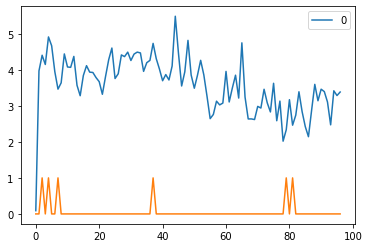

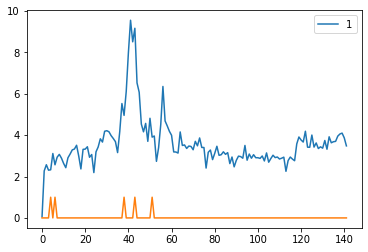

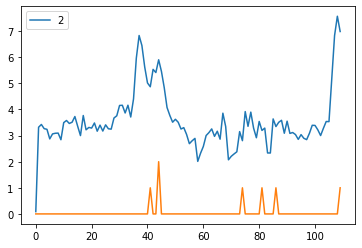

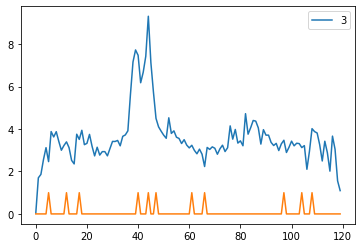

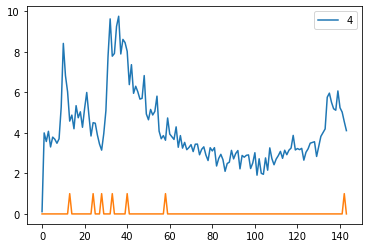

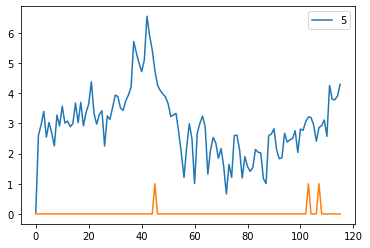

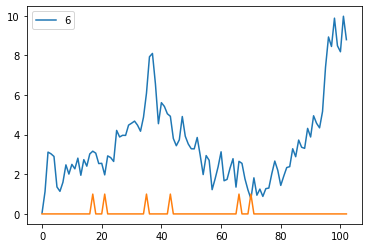

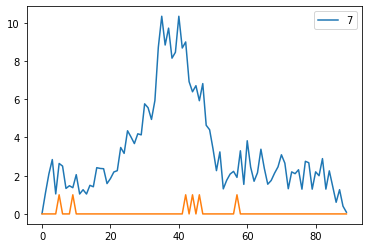

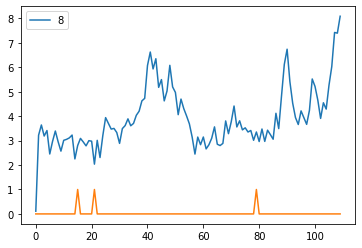

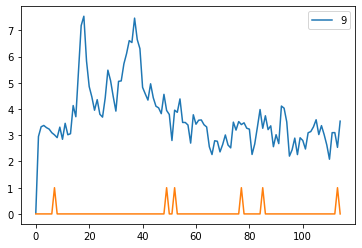

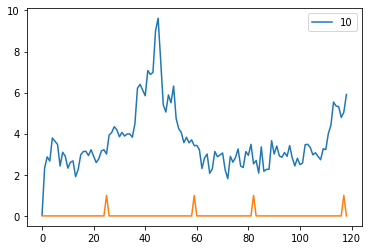

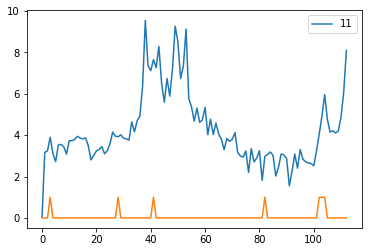

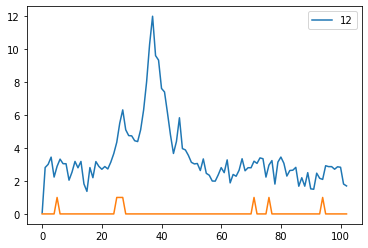

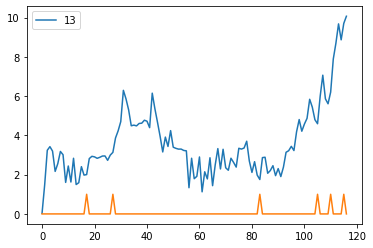

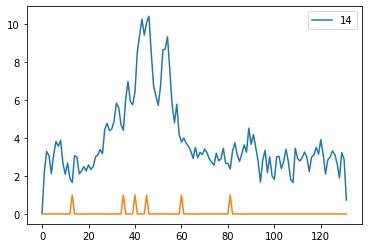

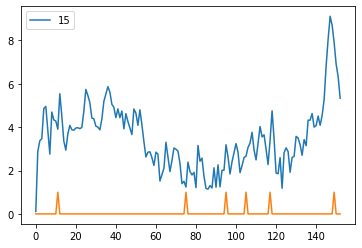

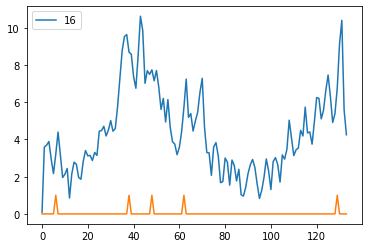

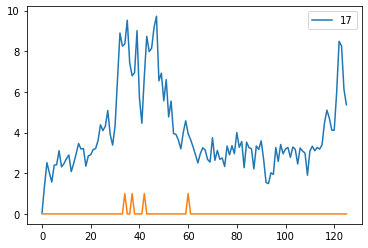

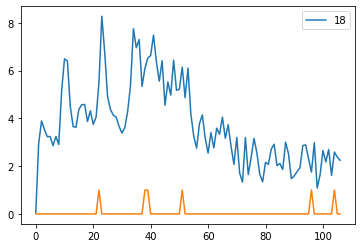

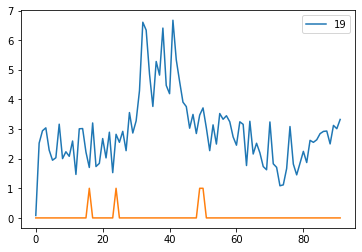

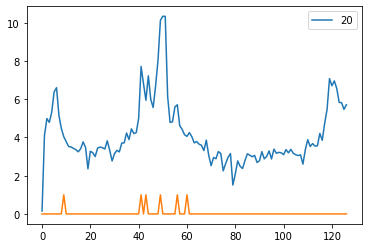

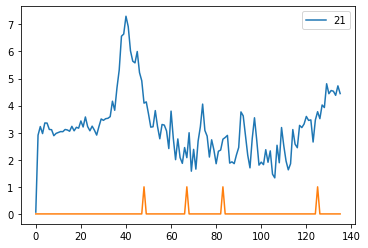

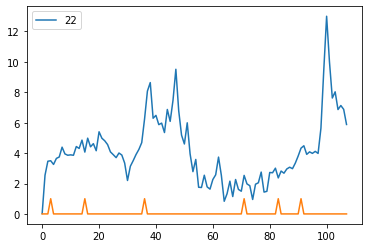

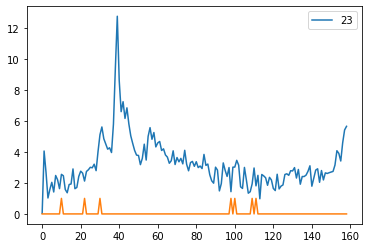

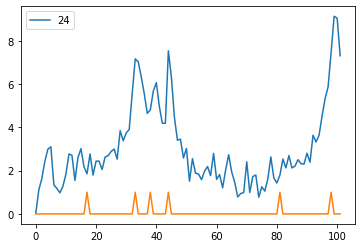

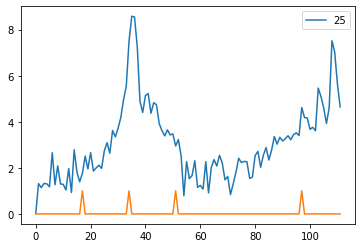

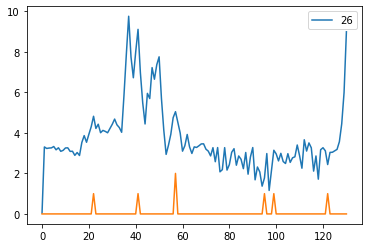

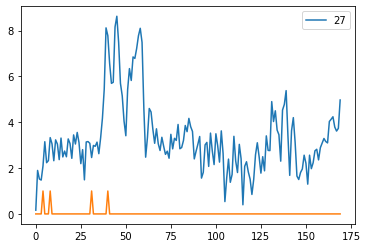

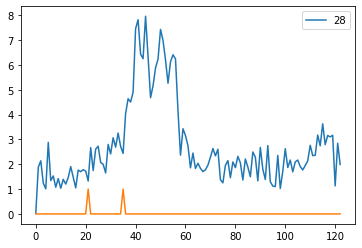

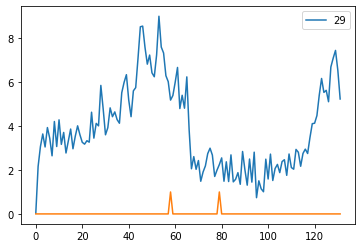

In [ ]:
for i in range(30):
  plt.plot(xss[0][i][:,85],label = i)
  plt.plot(ys['pmd'][i][:,85])  
  plt.legend()
  plt.show()

In [ ]:
xss[i][0][:,1].shape

(97,)

In [ ]:
ys['pmd'][3][:,1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
ys['pmd'][1].shape

(142, 94)

In [ ]:
model_path = 'models/pmd/iterations/checkpoints'
for epath in os.listdir(model_path):
models = [os.path.join(model_path, epath) ])   
os.listdir('models/pmd/iterations/checkpoints')
model = LFADS_Net(inputs_dim = num_cells[DATASET], T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams, seed = 0).to(device)
model.save_checkpoint(force = True, output= '.')


['2012150217_epoch_500_loss_1354-3551025390625.pth',
 '2012150232_epoch_728_loss_1333-013427734375.pth',
 '2012150242_epoch_908_loss_1329-2835693359375.pth',
 '2012150247_epoch_1000_loss_1342-3978271484375.pth',
 '2012150306_epoch_1293_loss_1325-8841552734375.pth',
 '2012150316_epoch_1471_loss_1345-869384765625.pth',
 '2012150319_epoch_1471_loss_1345-869384765625.pth',
 '2012150322_epoch_1471_loss_1345-869384765625.pth',
 '2012150324_epoch_1471_loss_1345-869384765625.pth',
 '2012150327_epoch_1471_loss_1345-869384765625.pth',
 '2012150330_epoch_1471_loss_1345-869384765625.pth',
 '2012150332_epoch_1471_loss_1345-869384765625.pth',
 '2012150335_epoch_1471_loss_1345-869384765625.pth',
 '2012150338_epoch_1471_loss_1345-869384765625.pth',
 '2012150340_epoch_1471_loss_1345-869384765625.pth',
 '2012150343_epoch_1471_loss_1345-869384765625.pth',
 '2012150345_epoch_1471_loss_1345-869384765625.pth',
 '2012150348_epoch_1471_loss_1345-869384765625.pth',
 '2012150351_epoch_1471_loss_1345-86938476562

In [ ]:
from lfads import batchify_random_sample
batch_example, ix = batchify_random_sample(train_data, 10)
print(ix)
pred_data = model.reconstruct(batch_example)
true_data = train_data[ix].cpu().numpy()
model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=4)

## Try to fit other denoising methods

In [ ]:
  

  
  # batch_example, ix = batchify_random_sample(train_data, 20)
  # print(ix)
  # pred_data = model.reconstruct(batch_example)*10
  # true_data = train_data[ix].cpu().numpy()
  # model.plot_traces(pred_data, true_data, mode='activity', norm=True,num_traces=12);
  # plt.show()

  # model.eval()
  # model.batch_size = 496
  # model.initialize(batch_size = 496)
  # with torch.no_grad():
  #   model.encode(train_data[:496,:,:])

  # ic_means = model.g0_mean.to('cpu')
  # ic_means_embedded = TSNE(n_components=2).fit_transform(ic_means)
  # plt.scatter(ic_means_embedded[:,0], ic_means_embedded[:,1], c=  colors);
  # plt.title('TSNE visualziation of LFADS inferred intial generator state.')
  # plt.show()

  #current_epochs += max_epochs 